# Tutorial notebook

This notebook will guide you through the FLeCS pipeline, including:
- Integrating a Gene Regulatory Network (GRN) with a single-cell dataset and preprocessing gene counts.
- Extracting cell trajectories from the single-cell data.
- Training the FLeCS model.
- Visualizing the predicted velocities and the learned regulation strengths that underlie their computation.

These experiments use a restricted number of 100 genes and should run in just a few minutes on a personal laptop.

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import random
import scanpy.external as sce
import scvelo as scv
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
import networkx as nx

from flecs.sc.dataset import Paul15Dataset
from flecs.sc.utils import compute_cell_knn_paths, train_epoch
from flecs.sc.model import GRNCellPop
from flecs.utils import get_project_root, set_seed

set_seed(0)

## Load data

We start by loading a single-cell dataset of myeloid differentiation, along with its metadata containing batch information. 

The two files can be downloaded from the Gene Expression Omnibus platform at [GSE72857](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE72857). 

In [2]:
adata = sc.read_csv(
    os.path.join(get_project_root(), "datasets", "Paul15", "GSE72857_umitab.txt"), 
    delimiter="\t"
).T

exp_des = pd.read_csv(
    os.path.join(get_project_root(), "datasets", "Paul15", "GSE72857_experimental_design.txt"), 
    skiprows=19, 
    sep="\t", 
    index_col="Well_ID"
)

adata.obs = exp_des.loc[adata.obs.index]

We now load a mouse Gene Regulatory Network (GRN) derived scATAC-seq. The file can be downloaded [here](https://drive.google.com/file/d/1UlK7a24xESJ5F3HCp80xTHPIgJGZYJGF/view?usp=drive_link) and has been obtained through the [CellOracle python library](https://github.com/morris-lab/CellOracle) using `co.data.load_mouse_scATAC_atlas_base_GRN()`.

In [3]:
grn_df = pd.read_csv(
    os.path.join(get_project_root(), "datasets", "Paul15", "mouse_scATAC_atlas_base_GRN.csv"), 
    index_col=0
)

## Preprocessing

We will now preprocess the single-cell dataset and combine it with the GRN.

Specifically, we will store the GRN's adjacency matrix as part of the `AnnData` object by assigning it to `adata.varp["grn_adj_mat"]`. This allows downstream methods to access the regulatory interactions alongside the gene expression data.

We extract a list of all genes covered by the GRN.

In [4]:
# Let us first get the TFs
all_grn_tfs = list(grn_df.columns[2:])
# Second let us get the other genes
all_grn_other_genes = grn_df["gene_short_name"].tolist()

all_grn_genes = np.unique(all_grn_tfs + all_grn_other_genes)

We keep the intersection between genes covered by the GRN and genes covered by the single-cell dataset, and subset the `adata` object.

In [5]:
all_keys_list = list(set(adata.var.index).intersection(all_grn_genes))
adata = adata[:, all_keys_list].copy()

We restricted ourselves to the four following batches:
- Unsorted myeloid cells
- Common Progenitor Cells (CMPs)
- Cells with knockout on the Cebpe gene
- Cells with knockout on the Cebpa gene

In [6]:
# Restrict to relevant cell populations
adata = adata[adata.obs["Batch_desc"].apply(lambda n: n in ['Unsorted myeloid',
                                                            'CMP Flt3+ Csf1r+', 
                                                            'Cebpe KO', 
                                                            'Cebpa KO'])].copy()

In [7]:
# adata.layers["counts"] = adata.X

We normalize and keep the 100 most highly variable genes.

In [8]:
sc.pp.filter_genes(adata, min_counts=1)
sc.pp.normalize_per_cell(adata, key_n_counts='n_counts_all')

# Find highly variable genes using the log1p normalized data
adata_copy = sc.pp.log1p(adata, copy=True)
sc.pp.highly_variable_genes(adata_copy, n_top_genes=100, flavor='cell_ranger')  # Expects logged data

adata.var['highly_variable'] = adata_copy.var['highly_variable']

adata = adata[:, adata.var['highly_variable']].copy()

We remove duplicated cells and apply the MAGIC denoising algorithm.

In [9]:
adata = adata[np.unique(adata.X, axis=0, return_index=True)[1]].copy()
sce.pp.magic(adata, t=3, n_pca=50, verbose=False)

We will now build the adjacency matrix of the GRN, in the order consistent with the columns of the `adata` object.

We first subset the GRN dataframe.

In [10]:
highly_variable_grn_genes = list(set(adata.var.index).intersection(all_grn_genes))

# Subset columns of GRN dataframe
highly_variable_tf = list(set(grn_df.columns).intersection(highly_variable_grn_genes))
grn_df_subset = grn_df[highly_variable_tf + ["gene_short_name"]]

# Subset lines of GRN dataframe
grn_df_subset = grn_df[grn_df["gene_short_name"].apply(lambda x: x in highly_variable_grn_genes)]

We build the adjacency matrix and add it to the `adata` object.

In [11]:
grn_adj_mat = np.zeros((adata.shape[1], adata.shape[1]))

for tf in highly_variable_tf:
    tf_index = list(adata.var.index).index(tf)
    target_genes = grn_df_subset[grn_df_subset[tf] == 1]["gene_short_name"].unique()
    target_indices = [list(adata.var.index).index(gene) for gene in target_genes]
    
    grn_adj_mat[tf_index, target_indices] = 1

In [12]:
adata.varp["grn_adj_mat"] = grn_adj_mat

In [13]:
adata.obs.reset_index(inplace=True)
adata.obs.index = adata.obs.index.astype(str)

In [14]:
adata

AnnData object with n_obs × n_vars = 7201 × 100
    obs: 'index', 'Seq_batch_ID', 'Amp_batch_ID', 'well_coordinates', 'Mouse_ID', 'Plate_ID', 'Batch_desc', 'Pool_barcode', 'Cell_barcode', 'RMT_sequence', 'Number_of_cells', 'CD34_measurement', 'FcgR3_measurement', 'n_counts_all'
    var: 'n_counts', 'highly_variable'
    varp: 'grn_adj_mat'

## Visualization

We compute and plot a UMAP visualization of our single-cell dataset.

In [15]:
sc.tl.pca(adata, svd_solver="arpack", n_comps=50)
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=50)
sc.tl.umap(adata, min_dist=0.3)

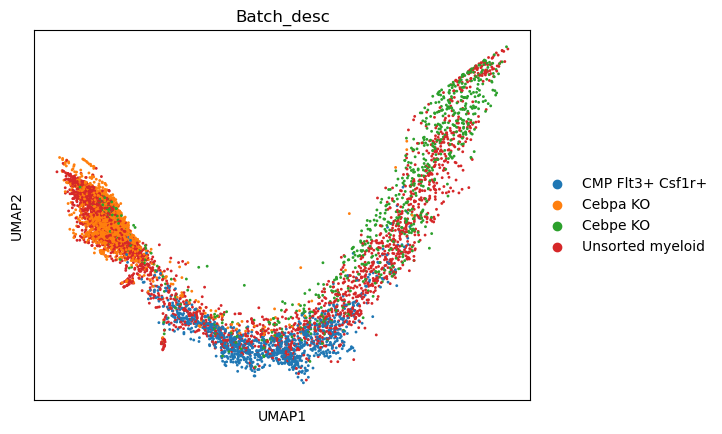

In [16]:
sc.pl.umap(adata, color="Batch_desc")

## Extract cell trajectories

We will focus on learning a model of dynamics going from progenitors (CMPs) to unsorted myeloid cells. To do so, we first need to extract cell trajectories going from CMPs to unsorted myeloid cells. 

We start by retrieving the indices of the rows in the `adata` object that correspond to CMP cells and unsorted cells.

In [17]:
# Get cell indices coming from the different batches
cmp_cells = list(adata.obs[adata.obs["Batch_desc"] == 'CMP Flt3+ Csf1r+'].index.astype("int"))
unsorted_cells = list(adata.obs[adata.obs["Batch_desc"] == 'Unsorted myeloid'].index.astype("int"))

We then extract trajectories from the single-cell dataset.

The method `compute_cell_knn_paths` first computes an Optimal Transport matching between the source and target cell populations. It then identifies the shortest path from each source cell to its matched target cell, based on a k-nearest neighbors graph. Each path is then downsampled to a fixed number of cells (5 in our case).

The method returns a dictionary where the *keys* are the indices of target cells, and the *values* are lists of cell indices representing the paths leading to these targets. Each path starts from a source cell.


In [18]:
# Extract trajectories from progenitor cells to either unsorted cells or one of the KO populations
unsorted_shortest_paths = compute_cell_knn_paths(adata, cmp_cells, unsorted_cells, n_bins=5)

# Add to the adata object
adata.uns["unsorted_shortest_paths"] = unsorted_shortest_paths

100%|████████████████████████████████████████████████████████████████| 3045/3045 [02:02<00:00, 24.83it/s]


We visualize a few extracted trajectories in UMAP space.

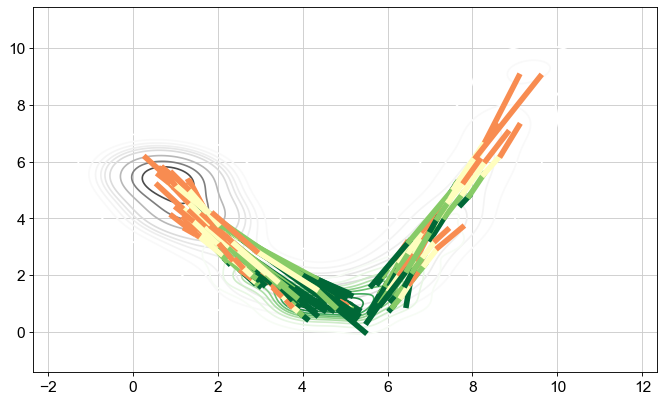

In [19]:
sc.set_figure_params(figsize=(10, 6))

# Distribution of unsorted myeloid in grey
coords = adata[adata.obs["Batch_desc"] == 'Unsorted myeloid'].obsm['X_umap']
sns.kdeplot(x=coords[:, 0], y=coords[:, 1], cmap="Greys")
# Distribution of unsorted myeloid in Green
coords = adata[adata.obs["Batch_desc"] == 'CMP Flt3+ Csf1r+'].obsm['X_umap']
sns.kdeplot(x=coords[:, 0], y=coords[:, 1], cmap="Greens")

# Plot a few extracted trajectories
for i, path in enumerate(unsorted_shortest_paths.values()):
    if i % 50 == 0:

        path_coord = adata.obsm["X_umap"][path]

        MAP = 'RdYlGn_r'
        NPOINTS = len(path_coord)

        cm = plt.get_cmap(MAP)

        for i in range(NPOINTS-1):
            plt.plot(path_coord[i:i+2, 0], path_coord[i:i+2, 1], c=cm(1.*i/(NPOINTS-1)), linewidth=5)

plt.show()

## Training

We will now train a FLeCS model.

In [20]:
train_len = 2048 # Number of trajectories (of length 5) in the training dataset
valid_len = 256
learning_rate = 0.005
batch_size = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

We initialize datasets and dataloaders, initialize the FLeCS model.

In [21]:
unsorted_dataset = Paul15Dataset(adata, unsorted_shortest_paths, path_length=5)
test_len = len(unsorted_dataset) - train_len - valid_len

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
    unsorted_dataset,
    [train_len, valid_len, test_len],
    generator=torch.Generator().manual_seed(0)
)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [22]:
mycellpop = GRNCellPop(adata=adata, 
                       batch_size=batch_size, 
                       n_latent_var=0, 
                       use_2nd_order_interactions=False).to(device)

optimizer = torch.optim.Adam(mycellpop.parameters(), lr=learning_rate)
loss = torch.nn.MSELoss()

Let's now train the FLeCS model for 20 epochs. 

In [23]:
for epoch in range(20):
    print("New epoch", epoch)
    train_epoch(mycellpop, train_dataloader, optimizer, path_length=5, loss=loss)

New epoch 0
train loss 3.488594599068165
New epoch 1
train loss 3.104165343567729
New epoch 2
train loss 3.0442269556224346
New epoch 3
train loss 3.0136527847498655
New epoch 4
train loss 2.9908360857516527
New epoch 5
train loss 2.9790264181792736
New epoch 6
train loss 2.966284856200218
New epoch 7
train loss 2.9586879070848227
New epoch 8
train loss 2.9466346818953753
New epoch 9
train loss 2.935949331149459
New epoch 10
train loss 2.915689177811146
New epoch 11
train loss 2.923676621168852
New epoch 12
train loss 2.908350368961692
New epoch 13
train loss 2.905360845848918
New epoch 14
train loss 2.8931602966040373
New epoch 15
train loss 2.8853987716138363
New epoch 16
train loss 2.8848114367574453
New epoch 17
train loss 2.8797234017401934
New epoch 18
train loss 2.873939758166671
New epoch 19
train loss 2.873161241412163


## Visualize Velocities

We now visualize the velocities learned by the model, projected onto UMAP space.

To embed the velocities into the UMAP space, we first recompute the k-nearest neighbors (kNN) graph, restricting it to the two cell populations of interest: CMPs and unsorted myeloid cells.


In [24]:
cmp_unsorted_adata = adata[cmp_cells + unsorted_cells]
sc.pp.neighbors(cmp_unsorted_adata, n_neighbors=30, n_pcs=50)

We set the batch size of the model to the number of cells in the `cmp_unsorted_adata`.

In [25]:
mycellpop.change_batch_size(len(cmp_unsorted_adata))

And we compute the velocities predicted by the model.

In [26]:
with torch.no_grad():
    gene_expr = torch.Tensor(cmp_unsorted_adata.X[:, :, None])
    velocities = mycellpop.get_derivatives(gene_expr)

velocities = velocities.cpu().numpy()[:, :, 0]

We now embed the velocities into the UMAP space.

In [27]:
# Add infered velocities to adata object for plotting
cmp_unsorted_adata.layers["velocity"] = velocities
cmp_unsorted_adata.layers["X"] = cmp_unsorted_adata.X

scv.tl.velocity_graph(cmp_unsorted_adata, xkey="X", n_jobs=8)

computing velocity graph (using 8/8 cores)


  0%|          | 0/4193 [00:00<?, ?cells/s]

    finished (0:00:12) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


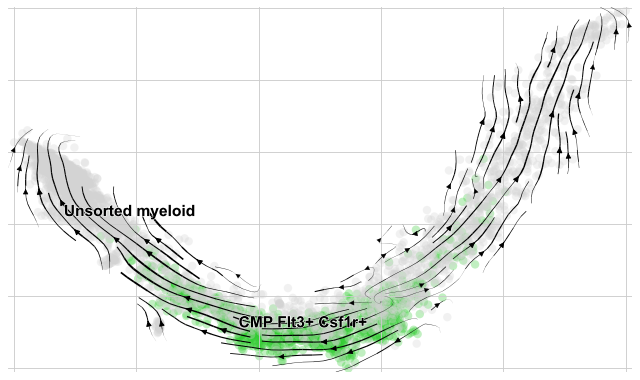

In [28]:
scv.pl.velocity_embedding_stream(cmp_unsorted_adata, 
                                 basis='umap', 
                                 color="Batch_desc", 
                                 layer="obs", 
                                 palette=["limegreen", "lightgrey"], 
                                 title="")

## Visualize learned regulation strengths

We now visualize the gene regulation strengths learned by the model, which underlie the prediction of cell velocities.

We start by retrieving the list of edges and associated weights from the FLeCS model

In [29]:
graph_edges = mycellpop["gene", "regulates", "gene"].edges.numpy().tolist()
regulation_strengths = mycellpop["gene", "regulates", "gene"].simple_conv_weights.detach().numpy()

Let's first visualize the distribution of weights

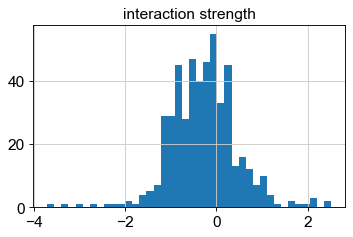

In [30]:
plt.rcParams["figure.figsize"] = (5, 3)
plt.hist(regulation_strengths.reshape(-1), bins=40)
plt.title("interaction strength")
plt.show()

We will now plot the learnt regulation strengths as a graph (edge color corresponding to regulation strength).

We first create a networkx graph object

In [31]:
# Format edge list and weights for networkx
graph_edges_weighted = [e + [{"strength": regulation_strengths[0, i].item()}] for i, e in enumerate(graph_edges)]

# Filter out edges with weight < 1. This is for better plot readability.
# This step is optional and can be commented out if all edges should be shown.
graph_edges_weighted = [e for e in graph_edges_weighted if  abs(e[2]['strength']) > 1] 

# Create the networkx graph.
g = nx.DiGraph()
g.add_nodes_from(range(100))
g.add_edges_from(graph_edges_weighted)
nx.set_node_attributes(g, {i: mycellpop["gene"].name[i] for i in range(100)}, name="name")

# Keep only the largest connected component.
largest_cc = max(nx.connected_components(g.to_undirected()), key=len)
g = g.subgraph(largest_cc)

Finally we plot the graph with the learnt regulation strengths.

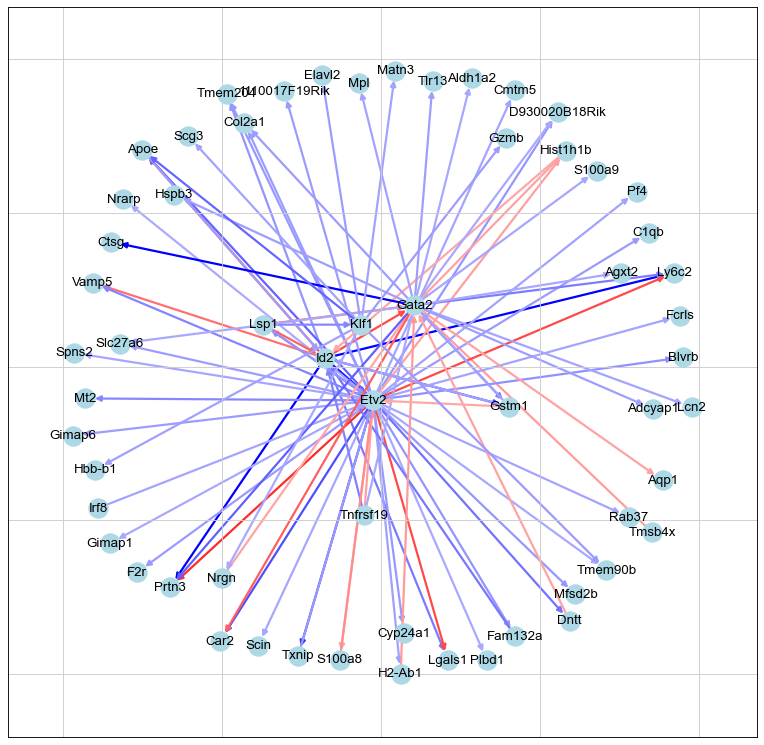

In [32]:
pos=nx.spring_layout(g, k=1.)

plt.rcParams["figure.figsize"] = (12, 12)
nx.draw_networkx(g, cmap = plt.get_cmap('jet'), pos=pos, node_color='lightblue',
        edge_color=list(nx.get_edge_attributes(g,'strength').values()),
        edge_cmap= plt.get_cmap('bwr'),
        with_labels = True,
        labels=nx.get_node_attributes(g, "name"),
        edge_vmin=-3., edge_vmax=3.,
        width=2)
plt.colorbar(shrink = 0.8)
plt.show()